In [1]:
# import required libraries
import os, sys
import numpy as np, pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.metrics import r2_score
import matplotlib.lines as mlines
import warnings

In [2]:
# Load All measured RDC Datasets for reference:
E0_rdc = pd.read_csv("data/E0-wt-TAR.sas.csv")
EI22_rdc = pd.read_csv("data/EI22-wt-TAR.sas.csv")
EII3_rdc = pd.read_csv("data/EII3-wt-TAR.sas.csv")
EII13_rdc = pd.read_csv("data/EII13-wt-TAR.sas.csv")

E0_N = E0_rdc.shape[0]
EI22_N = EI22_rdc.shape[0]
EII3_N = EII3_rdc.shape[0]
EII13_N = EII13_rdc.shape[0]

E0_rdc["construct"] = "E0"
EI22_rdc["construct"] = "EI22"
EII3_rdc["construct"] = "EII3"
EII13_rdc["construct"] = "EII13"

All_rdc = pd.concat([E0_rdc, EI22_rdc, EII3_rdc, EII13_rdc], ignore_index=True).drop(columns = "qc")
print("Read in total of %d RDCs:"%(All_rdc.shape[0]))

Read in total of 118 RDCs:


In [3]:
# Create masks for different domains and constructs:
df = All_rdc.copy()
maskE0 = df["construct"] == "E0"
maskEI22 = df["construct"] == "EI22"
maskEII3 = df["construct"] == "EII3"
maskEII13 = df["construct"] == "EII13"
maskH1 = (df.res_id_1.isin([18, 19, 20 ,21, 22]) | df.res_id_1.isin([40, 41, 42, 43, 44]))
maskH2 = (df.res_id_1.isin([27, 28, 29]) | df.res_id_1.isin([36, 37, 38]))
maskL = df.res_id_1.isin([30, 31, 32, 33, 34, 35])
maskB = df.res_id_1.isin([23, 24, 25])

In [4]:
# Define function for scaling PALES predicted RDCs wrt measured RDCs:
def get_scaled_rdcs(pm):
    mff = All_rdc.copy() 
    pmm = pm.copy()     
    pm = np.mean(pmm, axis=1)    
    maskE0 = mff["construct"] == "E0"
    maskEI22 = mff["construct"] == "EI22"
    maskEII3 = mff["construct"] == "EII3"
    maskEII13 = mff["construct"] == "EII13"
    mm = np.array(mff["rdc"], dtype=float)
    LE0 = np.dot(mm[maskE0],pm[maskE0])/np.dot(pm[maskE0],pm[maskE0])
    LEI22 = np.dot(mm[maskEI22],pm[maskEI22])/np.dot(pm[maskEI22],pm[maskEI22])
    LEII3 = np.dot(mm[maskEII3],pm[maskEII3])/np.dot(pm[maskEII3],pm[maskEII3])
    LEII13 = np.dot(mm[maskEII13],pm[maskEII13])/np.dot(pm[maskEII13],pm[maskEII13])
    pmm[maskE0] = pmm[maskE0] * LE0
    pmm[maskEI22] = pmm[maskEI22] * LEI22
    pmm[maskEII3] = pmm[maskEII3] * LEII3
    pmm[maskEII13] = pmm[maskEII13] * LEII13
    scaled_pm = pmm.copy()
    scaled_mm = mm.copy()
    return scaled_pm, scaled_mm

# Define function for scaling PALES predicted RDCs wrt measured RDCs for a subset:
def get_scaled_rdcs2(pm, indices_sel, indices_drop):
    mff = All_rdc.iloc[indices_sel,:].copy() 
    pmm = pm[indices_sel].copy()
    pmavg = np.mean(pmm, axis=1)    
    maskE0 = mff["construct"] == "E0"
    maskEI22 = mff["construct"] == "EI22"
    maskEII3 = mff["construct"] == "EII3"
    maskEII13 = mff["construct"] == "EII13"
    mm = np.array(mff["rdc"], dtype=float)
    LE0 = np.dot(mm[maskE0],pmavg[maskE0])/np.dot(pmavg[maskE0],pmavg[maskE0])
    LEI22 = np.dot(mm[maskEI22],pmavg[maskEI22])/np.dot(pmavg[maskEI22],pmavg[maskEI22])
    LEII3 = np.dot(mm[maskEII3],pmavg[maskEII3])/np.dot(pmavg[maskEII3],pmavg[maskEII3])
    LEII13 = np.dot(mm[maskEII13],pmavg[maskEII13])/np.dot(pmavg[maskEII13],pmavg[maskEII13])
    
    #print(indices_drop)
    mff = All_rdc.iloc[indices_drop,:].copy()
    #print(mff)
    pmm = pm[indices_drop].copy()
    pmm = np.mean(pmm, axis=1)
    mm = np.array(mff["rdc"], dtype=float)
    maskE0 = mff["construct"] == "E0"
    maskEI22 = mff["construct"] == "EI22"
    maskEII3 = mff["construct"] == "EII3"
    maskEII13 = mff["construct"] == "EII13"
    pmm[maskE0] = pmm[maskE0] * LE0
    pmm[maskEI22] = pmm[maskEI22] * LEI22
    pmm[maskEII3] = pmm[maskEII3] * LEII3
    pmm[maskEII13] = pmm[maskEII13] * LEII13
    #print(pmm)
    scaled_pm = pmm.copy()
    scaled_mm = mm.copy()
    return scaled_pm, scaled_mm


# Define function for calculating coeff of determination for ens. model RDCs
def calc_r2_denovo(x, y):
    TSS = np.sum((x - np.mean(x))**2)
    RSS = np.sum((x - y)**2)
    return (1-RSS/TSS)

In [5]:
# Settings for matplotlib
plt.rcParams["font.family"] = "Arial"
mpl.rcParams['axes.linewidth'] = 2
plt.rcParams.update({'font.size': 20})
warnings.filterwarnings('ignore')
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Arial'
sns.set_context('poster')

col_dict = {}
for i in range(17,23):
    col_dict[i] = "red"
for i in range(40,46):
    col_dict[i] = "red"
for i in range(26,30):
    col_dict[i] = "blue"
for i in range(36,40):
    col_dict[i] = "blue"
for i in range(23,26):
    col_dict[i] = "orange"
for i in range(30,36):
    col_dict[i] = "green"

fill_dict = {}
for i in range(17,23):
    fill_dict[i] = "full"
for i in range(40,46):
    fill_dict[i] = "none"
for i in range(26,30):
    fill_dict[i] = "full"
for i in range(36,40):
    fill_dict[i] = "none"
for i in range(23,26):
    fill_dict[i] = "full"
for i in range(30,36):
    fill_dict[i] = "full"
    
mk_dict = {
    'C6H6':'s', 'C8H8':'s', 'C2H2':'s', # aromatic
    "C1'H1'": 'o', "C4'H4'": 'o', # sugars
    "C5H5": 'D', #c5's
    "N1H1": '^', "N3H3": '^' # iminos
}


*********** Processing X-Val Repeat 1
	Found Lowest RMSD=2.8 Hz
	Found 107 RDCs selected, 11 RDCs dropped
	Appended subset data for XVal
*****************************************

*********** Processing X-Val Repeat 2
	Found Lowest RMSD=3.0 Hz
	Found 107 RDCs selected, 11 RDCs dropped
	Appended subset data for XVal
*****************************************

*********** Processing X-Val Repeat 3
	Found Lowest RMSD=2.5 Hz
	Found 107 RDCs selected, 11 RDCs dropped
	Appended subset data for XVal
*****************************************

*********** Processing X-Val Repeat 4
	Found Lowest RMSD=3.0 Hz
	Found 107 RDCs selected, 11 RDCs dropped
	Appended subset data for XVal
*****************************************

*********** Processing X-Val Repeat 5
	Found Lowest RMSD=3.0 Hz
	Found 107 RDCs selected, 11 RDCs dropped
	Appended subset data for XVal
*****************************************

*********** Processing X-Val Repeat 6
	Found Lowest RMSD=2.9 Hz
	Found 107 RDCs selected, 11 RDCs d

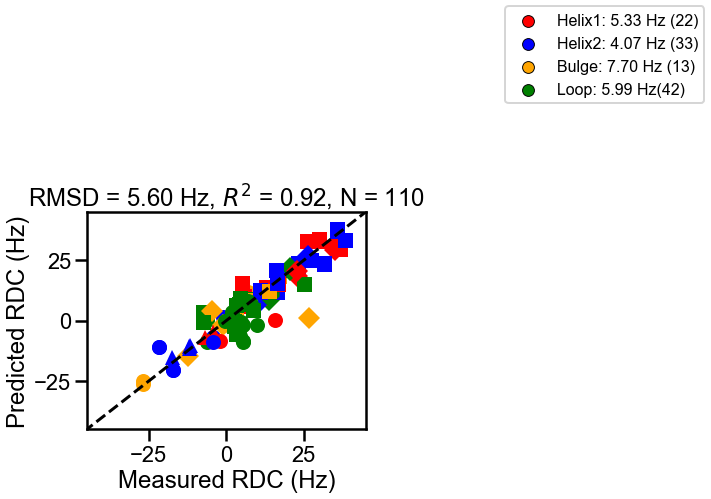

In [8]:
###################### UNBIASED INACTIVE #####################
xval_dir = "data/FARFAR_NMR_Cross_Validation_Inactive"

LocalList = []

for i in range(1, 11):
    print("\n*********** Processing X-Val Repeat %d"%(i))
    
    ## Find run with lowest RMSD
    sas_fin = open(xval_dir + "/%d_sas_output.txt"%(i), "r")
    LowestRMSDEnsIndices = []
    LowestRMSD = 100
    for line in sas_fin:
        words = line.strip().split()
        rmsd = float(words[1])
        if rmsd < LowestRMSD:
            LowestRMSD = rmsd
            LowestRMSDEnsIndices = np.array([int(word) for word in words[-20:]], dtype=int)
    print("\tFound Lowest RMSD=%3.1f Hz"%(LowestRMSD))
    
    ## Normalize dropped RDC predictions using selected ones
    selected_indices = np.array(np.genfromtxt(xval_dir + "/%d_selected_RDC_indices.txt"%(i)), dtype=int)
    dropped_indices = np.array(np.genfromtxt(xval_dir + "/%d_dropped_RDC_indices.txt"%(i)), dtype=int)
    
    full_pm = np.genfromtxt(xval_dir + "/%d_pmatrix_full.txt"%i, dtype=float)
    ens_pm = full_pm[:, LowestRMSDEnsIndices]

    print("\tFound %d RDCs selected, %d RDCs dropped"%(selected_indices.shape[0], dropped_indices.shape[0]))
    scaled_pm, mm = get_scaled_rdcs2(ens_pm, selected_indices, dropped_indices)
    All_rdc_temp = All_rdc.iloc[dropped_indices, :].copy().loc[:, ["res_id_1", "bond_vector", "construct"]]
    All_rdc_temp["mRDC"] = mm
    All_rdc_temp["pRDC"] = scaled_pm
    print("\tAppended subset data for XVal")
    print("*****************************************")
    
    LocalList.append(All_rdc_temp)

XValDF = pd.concat(LocalList)
print("Plotting combined results: ")

## Plot cross-validated measured vs predicted RDC correlation:

fig, ax = plt.subplots(figsize=(5,4))
mrdc_scaled = XValDF["mRDC"]
prdc_scaled = XValDF["pRDC"]

x = XValDF["mRDC"]
y = XValDF["pRDC"]
RMSD = np.sqrt(np.mean((x-y)**2))
R = np.corrcoef(x, y)[0, 1]
N = x.shape[0]
ax.set_title("RMSD = %3.2f Hz, $R^2$ = %3.2f, N = %d"%(RMSD, R, N))

for idx, row in XValDF.iterrows():
    plt.plot(row["mRDC"], row["pRDC"], color=col_dict[row["res_id_1"]], marker=mk_dict[row["bond_vector"]], markersize=15, 
                markeredgecolor="k", markeredgewidth=0)

# Make Legends:
helix_1_mask = (XValDF["res_id_1"] <= 22) | (XValDF["res_id_1"] >= 40)
x = mrdc_scaled[helix_1_mask]
y = prdc_scaled[helix_1_mask]
RMSD = np.sqrt(np.mean((x-y)**2))
R = np.corrcoef(x, y)[0, 1]
N = x.shape[0]
sns.scatterplot(x=[-100], y=[-100], color="red", marker="o", s=140, 
                label="Helix1: %3.2f Hz (%d)"%(RMSD, N), edgecolor="k")

helix_2_mask = ((XValDF["res_id_1"] >= 26)&(XValDF["res_id_1"] <= 29)) | ((XValDF["res_id_1"] >= 36)&(XValDF["res_id_1"] <= 39))
x = mrdc_scaled[helix_2_mask]
y = prdc_scaled[helix_2_mask]
RMSD = np.sqrt(np.mean((x-y)**2))
R = np.corrcoef(x, y)[0, 1]
N = x.shape[0]
sns.scatterplot(x=[-100], y=[-100], color="blue", marker="o", s=140, 
                label="Helix2: %3.2f Hz (%d)"%(RMSD, N), edgecolor="k")

bulge_mask = (XValDF["res_id_1"] >= 23)&(XValDF["res_id_1"] <= 25)
x = mrdc_scaled[bulge_mask]
y = prdc_scaled[bulge_mask]
RMSD = np.sqrt(np.mean((x-y)**2))
R = np.corrcoef(x, y)[0, 1]
N = x.shape[0]
sns.scatterplot(x=[-100], y=[-100], color="orange", marker="o", s=140, 
                label="Bulge: %3.2f Hz (%d)"%(RMSD, N), edgecolor="k")

loop_mask = (XValDF["res_id_1"] >= 30)&(XValDF["res_id_1"] <= 35)
x = mrdc_scaled[loop_mask]
y = prdc_scaled[loop_mask]
RMSD = np.sqrt(np.mean((x-y)**2))
R = np.corrcoef(x, y)[0, 1]
N = x.shape[0]
sns.scatterplot(x=[-100], y=[-100], color="green", marker="o", s=140, 
                label="Loop: %3.2f Hz(%d)"%(RMSD, N), edgecolor="k")

plt.rcParams.update({'font.size': 20})
ax.set_xlabel("Measured RDC (Hz)")
ax.set_ylabel("Predicted RDC (Hz)")
ax.set_xlim([-45, 45])
ax.set_ylim([-45, 45])
plt.plot([-50, 50], [-50, 50], "k--")
plt.legend(loc=(1.5, 1.5), prop={'size': 16})

#plt.savefig("plots/FARFAR_NMR_Cross_Validation_Inactive.pdf")

plt.show()
